### Введение

Построение композиции — важный подход в машинном обучении, который позволяет объединять большое количество слабых алгоритмов в один сильный. Данный подход широко используется на практике в самых разных задачах.

На лекциях был рассмотрен метод градиентного бустинга, который последовательно строит композицию алгоритмов, причем каждый следующий алгоритм выбирается так, чтобы исправлять ошибки уже имеющейся композиции. Обычно в качестве базовых алгоритмов используют деревья небольшой глубины, поскольку их достаточно легко строить, и при этом они дают нелинейные разделяющие поверхности.

Другой метод построения композиций — случайный лес. В нем, в отличие от градиентного бустинга, отдельные деревья строятся независимо и без каких-либо ограничений на глубину — дерево наращивается до тех пор, пока не покажет наилучшее качество на обучающей выборке.

В этом задании мы будем иметь дело с задачей классификации. В качестве функции потерь будем использовать log-loss:

$L(y,z)=-y\log z - (1-y)\log(1-z)$.

Здесь через $y$ обозначен истинный ответ, через $z$ — прогноз алгоритма. Данная функция является дифференцируемой, и поэтому подходит для использования в градиентном бустинге. Также можно показать, что при ее использовании итоговый алгоритм будет приближать истинные вероятности классов.

### Реализация в `sklearn`

В пакете `scikit-learn` градиентный бустинг реализован в модуле `ensemble` в виде классов `GradientBoostingClassifier` и `GradientBoostingRegressor`. Основные параметры, которые будут интересовать нас: `n_estimators`, `learning_rate`. Иногда может быть полезен параметр `verbose` для отслеживания процесса обучения.

Чтобы была возможность оценить качество построенной композиции на каждой итерации, у класса есть метод `staged_decision_function`. Для заданной выборки он возвращает ответ на каждой итерации.

Помимо алгоритмов машинного обучения, в пакете `scikit-learn` представлено большое число различных инструментов. В этом задании будет предложено воспользоваться функцией `train_test_split` модуля `cross_validation`. С помощью нее можно разбивать выборки случайным образом. На вход можно передать несколько выборок (с условием, что они имеют одинаковое количество строк). Пусть, например, имеются данные $X$ и $y$, где $X$ — это признаковое описание объектов, $y$ — целевое значение. Тогда следующий код будет удобен для разбиения этих данных на обучающее и тестовое множества:

`X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)`

Обратите внимание, что при фиксированом параметре `random_state` результат разбиения можно воспроизвести.

Метрика log-loss реализована в пакете `metrics`: `sklearn.metrics.log_loss`. Заметим, что данная метрика предназначена для классификаторов, выдающих оценку принадлежности классу, а не бинарные ответы. И градиентный бустинг, и случайный лес умеют строить такие прогнозы — для этого нужно использовать метод `predict_proba`:

`pred = clf.predict_proba(X_test)`

Метод `predict_proba` возвращает матрицу, $i$-й столбец которой содержит оценки принадлежности $i$-му классу.

Для рисования кривых качества на обучении и контроле можно воспользоваться следующим кодом:

`import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(test_loss, 'r', linewidth=2)
plt.plot(train_loss, 'g', linewidth=2)
plt.legend(['test', 'train'])`

#### Загрузите выборку из файла gbm-data.csv
Преобразуйте ее в массив `numpy`. В первой колонке файла с данными записано, была или нет реакция. Все остальные колонки (d1 - d1776) содержат различные характеристики молекулы, такие как размер, форма и т.д. Разбейте выборку на обучающую и тестовую, используя функцию `train_test_split` с параметрами `test_size = 0.8` и `random_state = 241`.

In [56]:
import pandas as pd
import numpy as np

df = pd.read_csv('gbm-data.csv')
df.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [57]:
from sklearn.cross_validation import train_test_split

X = df.iloc[:,1:].values
y = df['Activity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=241)

#### Обучите GradientBoostingClassifier 
С параметрами `n_estimators=250`, `verbose=True`, `random_state=241` и для каждого значения `learning_rate` из списка [1, 0.5, 0.3, 0.2, 0.1] проделайте следующее:
* Используйте метод `staged_decision_function` для предсказания качества на обучающей и тестовой выборке на каждой итерации.
* Преобразуйте полученное предсказание с помощью сигмоидной функции по формуле $1 / (1 + e^{−y_{pred}})$, где $y_{pred}$ — предсказаное значение.
* Вычислите и постройте график значений log-loss (которую можно посчитать с помощью функции `sklearn.metrics.log_loss`) на обучающей и тестовой выборках, а также найдите минимальное значение метрики и номер итерации, на которой оно достигается.

      Iter       Train Loss   Remaining Time 
         1           1.0190           16.95s
         2           0.9192           16.37s
         3           0.8272           14.84s
         4           0.7834           16.01s
         5           0.7109           16.68s
         6           0.6368           16.30s
         7           0.5797           15.93s
         8           0.5610           16.35s
         9           0.5185           16.29s
        10           0.4984           15.95s
        20           0.1999           14.63s
        30           0.1313           13.48s
        40           0.0790           12.78s
        50           0.0511           14.60s
        60           0.0352           14.30s
        70           0.0245           13.08s
        80           0.0162           12.02s
        90           0.0114           11.04s
       100           0.0077           10.15s
       200           0.0004            2.76s
180 0.000208576113948
0 0.582294259428
      Iter     

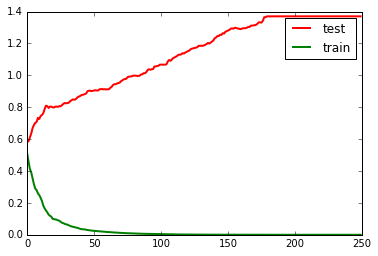

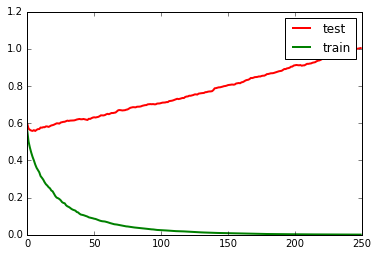

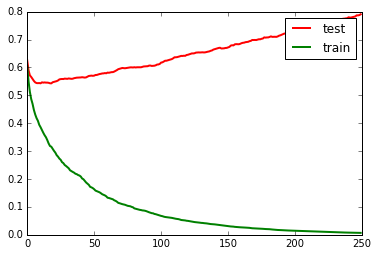

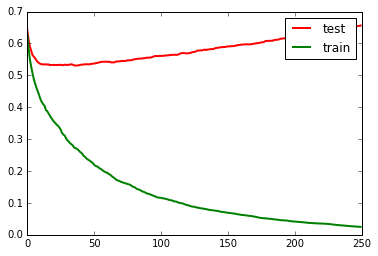

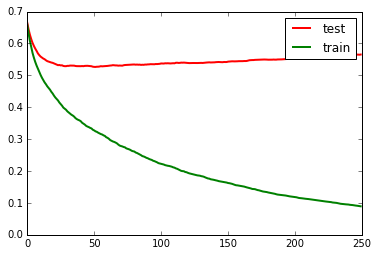

In [58]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
%matplotlib inline
import math
vecf = np.vectorize(lambda x: 1/(1+math.exp(-x)))

for rate in  [1, 0.5, 0.3, 0.2, 0.1]:
    clf = GradientBoostingClassifier(n_estimators=250,learning_rate=rate,verbose=True, random_state=241)
    clf.fit(X_train, y_train)
    y_pred_train = clf.staged_decision_function(X_train)
    y_pred_test = clf.staged_decision_function(X_test)

    l1 = list(y_pred_train)
    l2 = list(y_pred_test)
    
    train_loss=[]
    test_loss=[]
    for pred1,pred2 in zip(l1,l2):
        y_sig_train = vecf(pred1)
        train_loss.append(log_loss(y_train, y_sig_train))
        y_sig_test = vecf(pred2)
        test_loss.append(log_loss(y_test, y_sig_test))

    plt.figure()
    plt.plot(test_loss, 'r', linewidth=2)
    plt.plot(train_loss, 'g', linewidth=2)
    plt.legend(['test', 'train'])
    
    train_min = min(train_loss)
    test_min = min(test_loss)
    print(train_loss.index(train_min), train_min)
    print(test_loss.index(test_min), test_min)

#### Как можно охарактеризовать график качества на тестовой выборке, начиная с некоторой итерации: переобучение (overfitting) или недообучение (underfitting)? 
В ответе укажите одно из слов overfitting либо underfitting.

In [3]:
# Здесь ваш код

#### Приведите минимальное значение log-loss 
На тестовой выборке и номер итерации, на котором оно достигается, при learning_rate = 0.2.

In [4]:
# Здесь ваш код

#### На этих же данных обучите RandomForestClassifier
С количеством деревьев, равным количеству итераций, на котором достигается наилучшее качество у градиентного бустинга из предыдущего пункта, c random_state=241 и остальными параметрами по умолчанию. Какое значение log-loss на тесте получается у этого случайного леса? (Не забывайте, что предсказания нужно получать с помощью функции predict_proba. В данном случае брать сигмоиду от оценки вероятности класса не нужно)

In [59]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=36, random_state=241)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=36, n_jobs=1,
            oob_score=False, random_state=241, verbose=0, warm_start=False)

In [60]:
y_pred = clf.predict_proba(X_test)

In [61]:
loss = log_loss(y_test, y_pred)
loss

0.54138128618040693